In [ ]:
import pandas as pd
import numpy as np


def PrepX(X:pd.DataFrame):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    new_cols = []
    for col, t in X_types.items():

        #Leaves numeric columns unchanged, no scaling needed for tree-based methods, scale invariant
        if t in ['int', 'float']: 
            new_cols.append(X[col].copy())
            continue

        #Create dummies for categorical (str) columns
        if t == 'object': 
            new_col = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    return X_prep

#Split data into train and validation set. 
def Split(X:pd.DataFrame, Y:pd.DataFrame, TestSize:float, random_state:int=42):

    split_index = np.random.RandomState(random_state) \
                           .choice([True, False], size=len(Y), p=[TestSize,1-TestSize])
    
    X_test = X[split_index]
    X_train = X[~split_index]
    Y_test = Y[split_index]
    Y_train = Y[~split_index]

    return X_test, X_train, Y_test, Y_train



# Load Data and Prepare for Processesing (PrepX)
with open('../../data/DatasetCleaned.csv', 'r') as f:
    DATA = pd.read_csv(f)

Y_DATA = np.log(DATA['SalePrice'].copy().values)
VAR_DEPENDENT = 'SalePrice'

X_DATA = DATA.copy().drop(columns=['SalePrice','Unnamed: 0'])
X_DATA = PrepX(X_DATA)
VAR_NAMES = X_DATA.columns

#Create Validation Set 
VALIDATION_SET = True
if VALIDATION_SET: 
    X_VAL, X_DATA, Y_VAL, Y_DATA = Split(X_DATA, Y_DATA, 0.05, 1)
    X_VAL = X_VAL.values.reshape(-1, X_VAL.shape[1])

X_DATA = X_DATA.values.reshape(-1,X_DATA.shape[1])

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score


#Automatically GridSearch Random Forest
ForestModel = RandomForestRegressor(n_estimators=250, n_jobs=-1, random_state=42)
test_params = {
        'max_depth':list(range(3,11)),
        'min_samples_leaf':[5,10,25,50,100],
        'max_features':['sqrt','log2',10]
    }

GridTunedForest = GridSearchCV(
        ForestModel, test_params,
        scoring={'R2':make_scorer(r2_score)}, refit='R2', 
        cv=KFold(5), return_train_score=True,
        verbose=3, n_jobs=-1
    )

GridTunedForest.fit(X_DATA,Y_DATA)

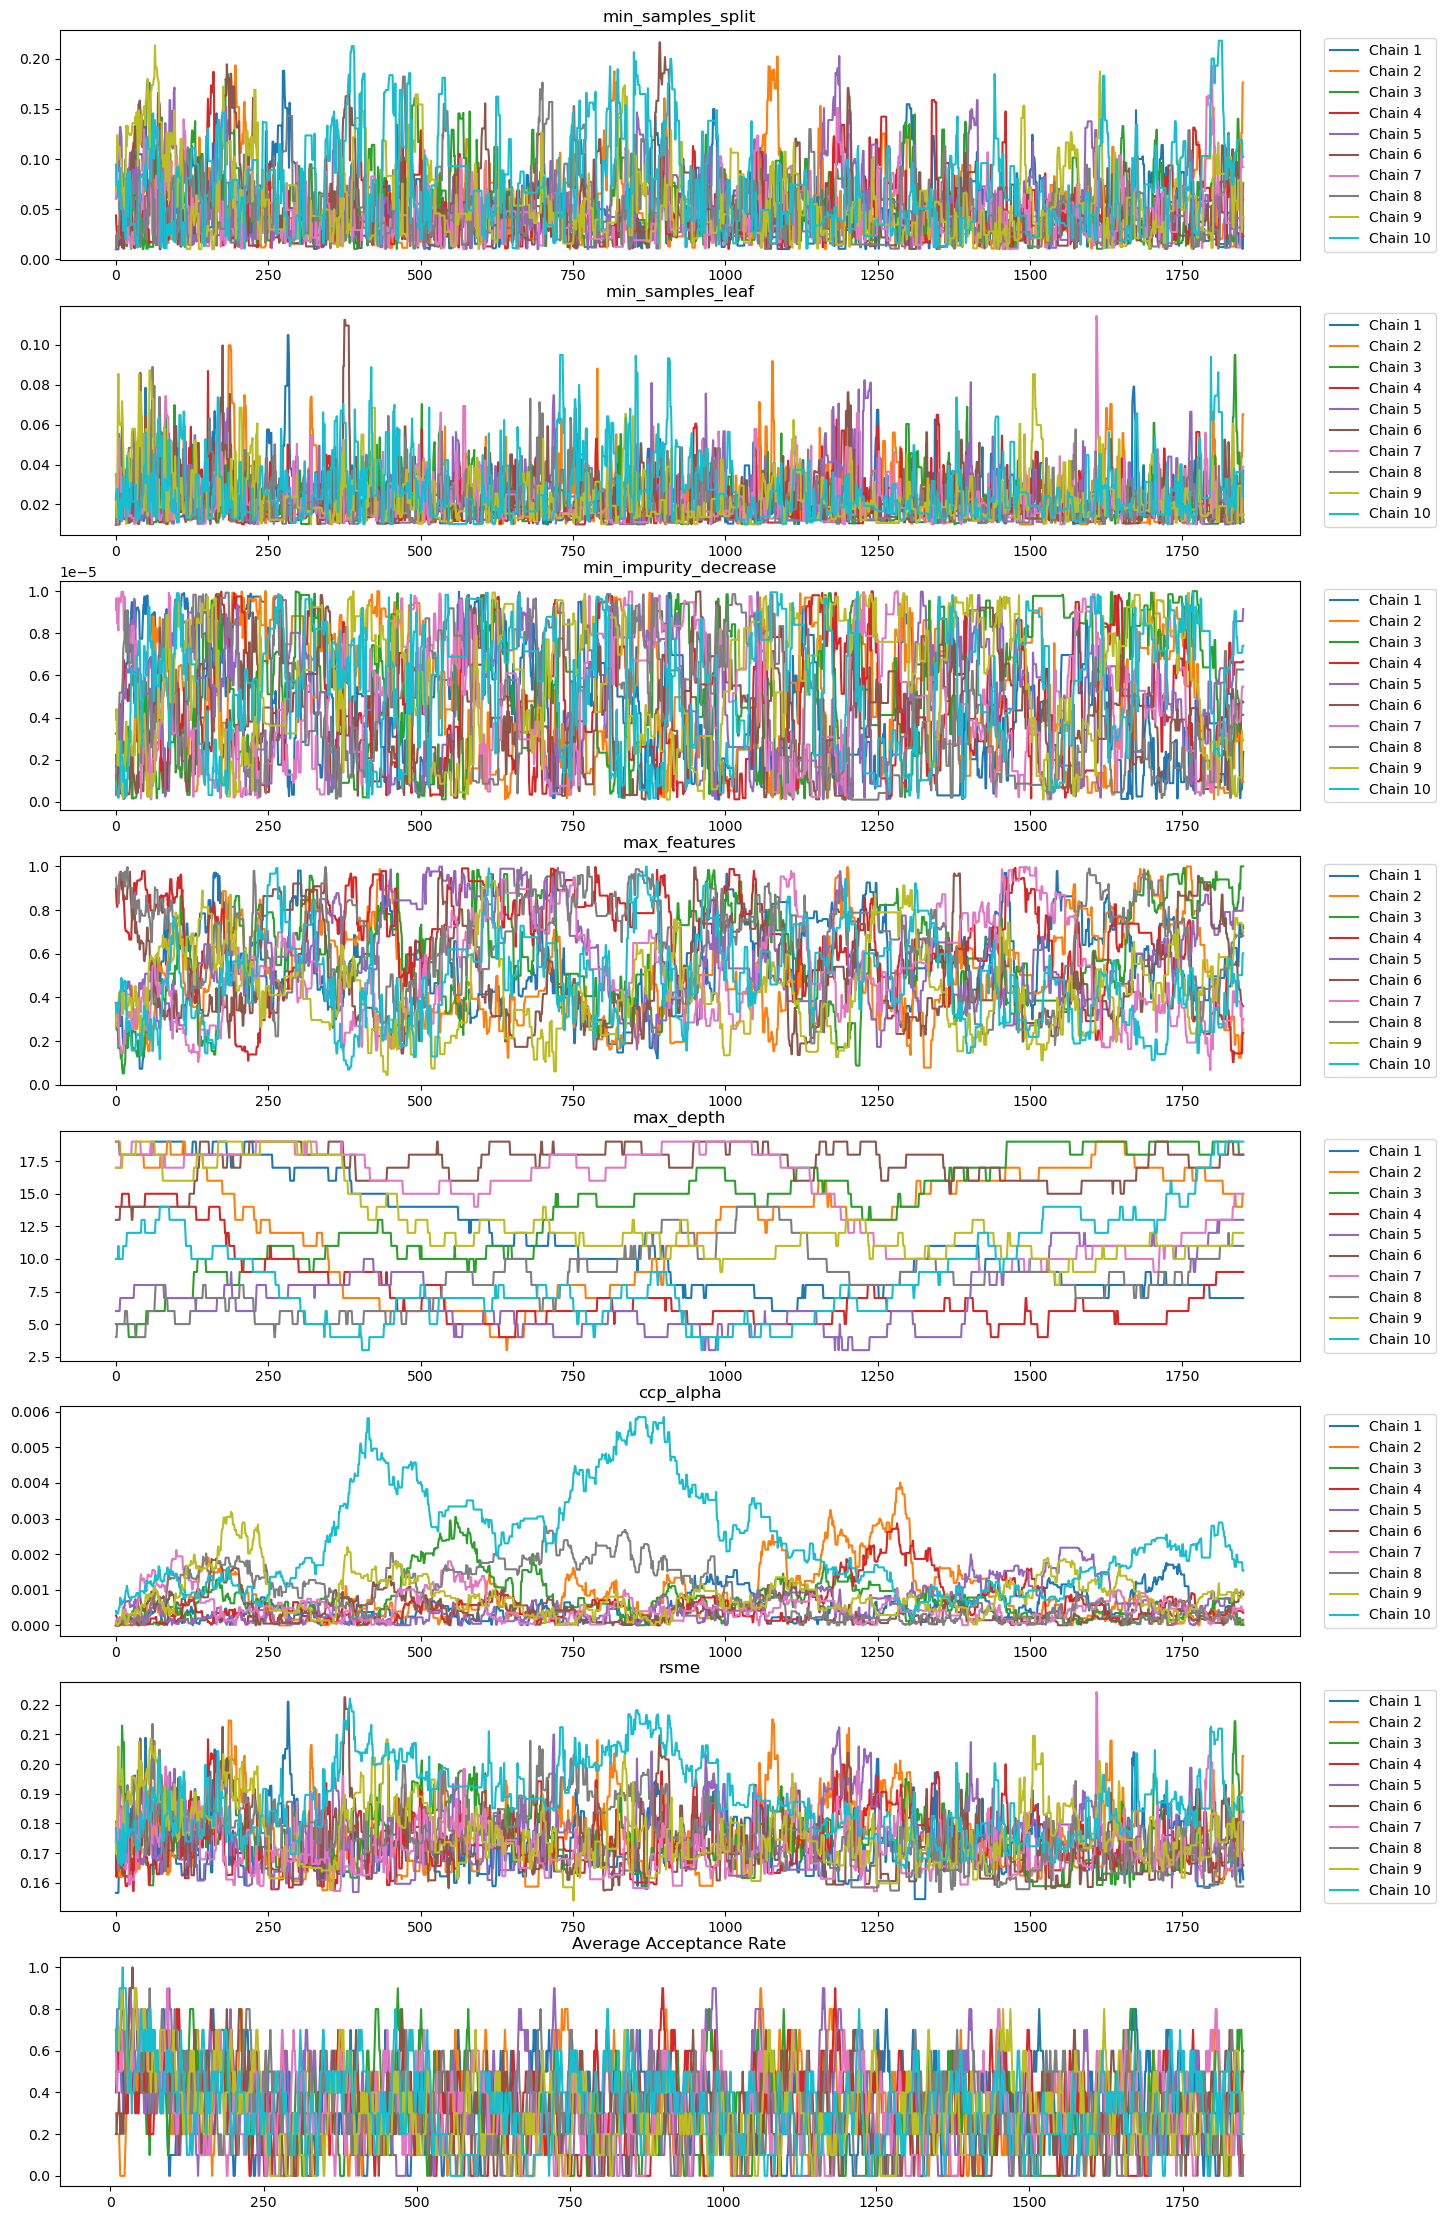

In [1]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

#MCMC_Tuning is run from CMD to increase efficiency
with open('models/MCMC_RandomForestRegressor_Autosave.sav', 'rb') as f: chains_raw = pickle.load(f)

tuned_parameters = list(chains_raw[0]['samples'][0]['params'].keys()) + ['rsme']
chains = [pd.DataFrame(chain['samples']) for chain in chains_raw]

fig, axes = plt.subplots(len(tuned_parameters)+1, 1, figsize=(16,len(tuned_parameters)*4))
axes = axes.flatten()

#Generate Plots for Tuned Parameters and RSME over iterations 
for parameter, ax in zip(tuned_parameters, axes):
    for i, chain in enumerate(chains):
        ax.plot(chain.index, chain[parameter], label=f'Chain {i+1}')
        ax.set_title(parameter)
        ax.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),borderaxespad=0)

#Generate Plot for Acceptance Rate over time
window = 10
for i, chain in enumerate(chains_raw):
    accept_hist = chain['acceptance_history']
    avrg_accept = np.convolve(accept_hist, np.ones(window)/window, mode='valid')
    x_moving = np.arange(window-1,len(accept_hist))
    axes[-1].plot(x_moving, avrg_accept, label=f'Chain {i+1}')
    axes[-1].set_title('Average Acceptance Rate')